# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).


**Note**: Make sure you make a validation split of your ID dataset for testing.

In [60]:
import torch
import torchvision
import os
from torchvision.datasets import FakeData
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
from sklearn import metrics
import random
from torchvision.datasets import CIFAR10, CIFAR100
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Subset
from sklearn.metrics import precision_score, recall_score

In [61]:
from myResNet.MyResnet import MyResNet
from Trainer.Trainer import Trainer, FGSM

In [62]:
layers_deeper_net = [
    ("Conv2d", 3, 64, 3, 1, 1, "zeros", "ReLU"),
    ("BatchNorm2d", 64),
    ("Conv2d", 64, 64, 3, 1, 1, "zeros", "ReLU"),
    ("Dropout", 0.5),
    ("BatchNorm2d", 64),
    ("MaxPool2d", 2),

    ("Conv2d", 64, 128, 3, 1, 1, "zeros", "ReLU"),
    ("BatchNorm2d", 128),
    ("Conv2d", 128, 128, 3, 1, 1, "zeros", "ReLU"),
    ("BatchNorm2d", 128),
    ("MaxPool2d", 2),

    ("Conv2d", 128, 256, 3, 1, 1, "zeros", "ReLU"),
    ("BatchNorm2d", 256),
    ("Conv2d", 256, 256, 3, 1, 1, "zeros", "ReLU"),
    ("BatchNorm2d", 256),
    ("MaxPool2d", 2),

    ("Linear", 4096, 512, 1, 256, "ReLU"),
    ("Dropout", 0.5),
    ("Linear", 256, 128, 2, 10)
]

best_CNN = MyResNet(layers_deeper_net, data_shape=(3,32,32),skip_dict={1:2,6:8,10:11})
best_CNN.load_state_dict(torch.load('/home/tommaso/Documents/deep_learning/lab1/bestCNN.pt')) 

<All keys matched successfully>

In [63]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_CIFAR100 = transforms.Compose([transforms.ToTensor(),
                      transforms.Normalize(mean=[0.5071, 0.4865, 0.4409],std=[0.2673, 0.2564, 0.2762])])



batch_size = 128


ds_train = CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

ds_test = CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

ds_OOD = CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform_CIFAR100
)

In [64]:
ID_objects = ds_test.classes
CIFAR100_classes = ds_OOD.classes

cifar100_to_cifar10 = {
    # superclasse: aquatic mammals
    'beaver': None,
    'dolphin': None,
    'otter': None,
    'seal': None,
    'whale': None,

    # fish
    'aquarium_fish': None,
    'flatfish': None,
    'ray': None,
    'shark': None,
    'trout': None,

    # flowers
    'orchid': None,
    'poppy': None,
    'rose': None,
    'sunflower': None,
    'tulip': None,

    # food containers
    'bottle': None,
    'bowl': None,
    'can': None,
    'cup': None,
    'plate': None,

    # fruit and vegetables
    'apple': None,
    'mushroom': None,
    'orange': None,
    'pear': None,
    'sweet_pepper': None,

    # household electrical devices
    'clock': None,
    'keyboard': None,
    'lamp': None,
    'telephone': None,
    'television': None,

    # household furniture
    'bed': None,
    'chair': None,
    'couch': None,
    'table': None,
    'wardrobe': None,

    # insects
    'bee': None,
    'beetle': None,
    'butterfly': None,
    'caterpillar': None,
    'cockroach': None,

    # large carnivores
    'bear': None,
    'leopard': None,
    'lion': None,
    'tiger': None,
    'wolf': None,

    # large man-made outdoor things
    'bridge': None,
    'castle': None,
    'house': None,
    'road': None,
    'skyscraper': None,

    # large natural outdoor scenes
    'cloud': None,
    'forest': None,
    'mountain': None,
    'plain': None,
    'sea': None,

    # large omnivores and herbivores
    'camel': None,
    'cattle': None,
    'chimpanzee': None,
    'elephant': None,
    'kangaroo': None,

    # medium-sized mammals
    'fox': None,
    'porcupine': None,
    'possum': None,
    'raccoon': None,
    'skunk': None,

    # non-insect invertebrates
    'crab': None,
    'lobster': None,
    'snail': None,
    'spider': None,
    'worm': None,

    # people
    'baby': None,
    'boy': None,
    'girl': None,
    'man': None,
    'woman': None,

    # reptiles
    'crocodile': None,
    'dinosaur': None,
    'lizard': None,
    'snake': None,
    'turtle': None,

    # small mammals
    'hamster': None,
    'mouse': None,
    'rabbit': None,
    'shrew': None,
    'squirrel': None,

    # trees
    'maple_tree': None,
    'oak_tree': None,
    'palm_tree': None,
    'pine_tree': None,
    'willow_tree': None,

    # vehicles 1
    'bicycle': 'automobile',
    'bus': 'automobile',
    'motorcycle': 'automobile',
    'pickup_truck': 'truck',
    'train': None,

    # vehicles 2
    'lawn_mower': None,
    'rocket': None,
    'streetcar': None,
    'tank': None,
    'tractor': None,

    # birds
    'parrot': 'bird',
    'woodpecker': 'bird',

    # cats
    'tiger_cat': 'cat',
    'house_cat': 'cat',

    # dogs
    'wolf': None,  # lupo selvatico -> no
    'fox': None,
    'coyote': None,
    'dingo': None,

    # frogs
    'frog': 'frog',

    # horses
    'horse': 'horse',

    # ships & planes
    'airplane': 'airplane',
    'warplane': 'airplane',
    'ship': 'ship',
    'airliner': 'airplane',

    # trucks
    'pickup_truck': 'truck',
    'tank_truck': 'truck',
}


indexes_OOD = []

for example_index in range(len(ds_OOD)):
    
    example = ds_OOD[example_index]
    label = CIFAR100_classes[example[1]]

    if cifar100_to_cifar10[label] == None:
        indexes_OOD.append(example_index)

OOD_classes = []

for k,v in cifar100_to_cifar10.items():
    if v == None:
        OOD_classes.append(k)

ds_OOD = Subset(ds_OOD,indexes_OOD)
ds_OOD = ds_OOD.dataset
ds_OOD.classes = OOD_classes
print(len(ds_OOD))
print(ds_OOD.classes)

50000
['beaver', 'dolphin', 'otter', 'seal', 'whale', 'aquarium_fish', 'flatfish', 'ray', 'shark', 'trout', 'orchid', 'poppy', 'rose', 'sunflower', 'tulip', 'bottle', 'bowl', 'can', 'cup', 'plate', 'apple', 'mushroom', 'orange', 'pear', 'sweet_pepper', 'clock', 'keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 'bear', 'leopard', 'lion', 'tiger', 'wolf', 'bridge', 'castle', 'house', 'road', 'skyscraper', 'cloud', 'forest', 'mountain', 'plain', 'sea', 'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'crab', 'lobster', 'snail', 'spider', 'worm', 'baby', 'boy', 'girl', 'man', 'woman', 'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 'maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree', 'train', 'lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor', 'coyote', 'dingo

In [65]:
def compute_scores(logits, score_function = 'max_softmax', T = 1):
    
    if score_function == 'max_softmax':
        score = F.softmax(logits/T, 1)
        score = score.max(dim=1)[0]

    return score


def compute_T_scaling(logits, y_gt,y_pred, T_vec,plots = False):

    best_ece = 1
    T_best = T_vec[0]
    best_scores, best_accuracies, e_best = [],[],[]
    
    for temp in T_vec:
        scores_test = compute_scores(logits, score_function = 'max_softmax', T=temp)
     
        b, e = np.histogram(scores_test.cpu(), bins=10)
      
        scores, accuracies = [],[]
        ece = 0
        
        for i in range(0,len(e)-1):
            inside_id = np.where((scores_test.cpu() >= e[i]) & (scores_test.cpu() < e[i+1]))[0]

            if len(inside_id):
                conf = scores_test[inside_id].mean().item()
            else:
                conf = 0.0
            scores.append(conf)


            if len(inside_id):
                a = torch.sum(y_pred[inside_id] == y_gt[inside_id])/len(inside_id)
                a = a.item()
            else:
                a = 0
            accuracies.append(a)
        
            ece += ((len(inside_id))/len(scores_test))*abs(a-scores[i])
          
        if ece < best_ece:
            best_ece = ece
            T_best = temp
            best_scores, best_accuracies = scores, accuracies
            e_best = e


    
    if plots:

        if max(best_accuracies)<max(best_scores):
            plt.bar(e[:-1], best_scores, width=np.diff(e_best), edgecolor="black", align="edge",label='scores', facecolor='red')
            plt.title(f'ECE:{100*best_ece:2.2f}%, T: {T_best}')
            plt.legend()
               #plt.show()
               
            plt.bar(e[:-1], best_accuracies, width=np.diff(e_best), edgecolor="black", align="edge",label='accuracies', facecolor='blue')
            plt.legend()
            plt.show()
        
        else:
            plt.bar(e[:-1], best_accuracies, width=np.diff(e_best), edgecolor="black", align="edge",label='accuracies',facecolor='blue')
            plt.legend()
   
            plt.bar(e[:-1], best_scores, width=np.diff(e_best), edgecolor="black", align="edge",label='scores',facecolor='red')
            plt.title(f'ECE:{100*best_ece:2.2f}%, T: {T_best}')
            plt.legend()
               #plt.show()
               
            plt.show()
            
        
    return best_ece,T_best

In [69]:
def OOD_pipeline(model, device, ID_ds, OOD_ds, batch_size, num_workers,seed=42, plot=True, T_scaling=None, plot_T_scaling=False,score_function='max_softmax', plot_performances=True):
    import torch
    import random
    import numpy as np
    from torch.utils.data import DataLoader
    from sklearn import metrics
    import matplotlib.pyplot as plt
    from sklearn.calibration import CalibrationDisplay

    # For reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Loaders
    test_loader = DataLoader(ID_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers)
    fake_loader = DataLoader(OOD_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers)

    model.to(device)
    model.eval()

    N = len(test_loader.dataset)
    M = len(fake_loader.dataset)

    y_gt = torch.zeros(N, dtype=torch.long, device=device)
    y_pred = torch.zeros(N, dtype=torch.long, device=device)
    test_logits = torch.zeros((N, len(ID_ds.classes)), dtype=torch.float, device=device)
    fake_logits = torch.zeros((M, len(ID_ds.classes)), dtype=torch.float, device=device)

    start = 0
    with torch.no_grad():
        for data in test_loader:
            x, y = data
            x, y = x.to(device), y.to(device)
            logits = model(x)
            bsz = y.size(0)
            end = start + bsz

            y_gt[start:end] = y
            y_pred[start:end] = logits.argmax(1)
            test_logits[start:end, :] = logits

            start = end

    start = 0
    with torch.no_grad():
        for data in fake_loader:
            x, y = data
            x = x.to(device)
            logits = model(x)
            bsz = x.size(0)
            end = start + bsz
            fake_logits[start:end, :] = logits
            start = end

    if T_scaling is not None:
        best_ece, T_best = compute_T_scaling(test_logits, y_gt, y_pred, T_scaling, plot_T_scaling)

        if plot_T_scaling:
            fig, ax = plt.subplots(figsize=(6, 6))
            for temp in T_scaling:
                scores_temp = compute_scores(test_logits, score_function='max_softmax', T=temp)
                CalibrationDisplay.from_predictions(
                    (y_gt == y_pred).cpu(),
                    scores_temp.cpu(),
                    ax=ax,
                    label=f'T: {temp:.2f}',
                    n_bins=10
                )
            ax.set_title("Calibration curve for different temperatures")
            plt.show()

        scores_test = compute_scores(test_logits, score_function='max_softmax', T=T_best)
        scores_fake = compute_scores(fake_logits, score_function='max_softmax', T=T_best)
        scores_test_preT = compute_scores(test_logits, score_function='max_softmax')
        scores_fake_preT = compute_scores(fake_logits, score_function='max_softmax')

    else:
        scores_test = compute_scores(test_logits, score_function=score_function)
        scores_fake = compute_scores(fake_logits, score_function=score_function)

    if plot:
        if plot_performances:
            accuracy = (y_pred == y_gt).sum().item() / len(y_gt)
            print(f'Accuracy: {accuracy:.4f}')
            
            cm = metrics.confusion_matrix(y_gt.cpu(), y_pred.cpu())
            cmn = cm.astype(np.float32)
            cmn /= cmn.sum(1, keepdims=True)
            cmn = (100 * cmn).astype(np.int32)
            
            fig, ax = plt.subplots(figsize=(8, 8))
            disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=ID_ds.classes)
            disp.plot(ax=ax, cmap='viridis')
            
            # Ruota le etichette sull'asse X
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
            
            ax.set_title("Confusion Matrix")
            plt.tight_layout()
            plt.show()


        if T_scaling:
            
            plt.hist(scores_test_preT.cpu(), density=True, alpha=0.5, bins=25, label='ID (before T)')
            plt.hist(scores_fake_preT.cpu(), density=True, alpha=0.5, bins=25, label='OOD (before T)')
            plt.title("Distribution before T-scaling")
            plt.legend()
            plt.show()

            plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25, label='ID (after T)')
            plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25, label='OOD (after T)')
            plt.title("Distribution after T-scaling")
            plt.legend()
            plt.show()

            
            y_labels_ID = (y_gt == y_pred).cpu()
            fig, ax = plt.subplots(figsize=(6, 6))
            metrics.RocCurveDisplay.from_predictions(
                y_labels_ID, scores_test_preT.cpu(),
                ax=ax, name='ID ROC before T', color='red')
            metrics.RocCurveDisplay.from_predictions(
                y_labels_ID, scores_test.cpu(),
                ax=ax, name='ID ROC after T', color='green')
            ax.set_title("ROC curve: ID-only (calibration)")
            plt.show()

        
            y_labels_OOD = torch.cat([
                torch.ones_like(scores_test),
                torch.zeros_like(scores_fake)
            ]).cpu()
            y_scores_OOD_preT = torch.cat([scores_test_preT, scores_fake_preT]).cpu()
            y_scores_OOD = torch.cat([scores_test, scores_fake]).cpu()

            fig, ax = plt.subplots(figsize=(6, 6))
            metrics.PrecisionRecallDisplay.from_predictions(
                y_labels_OOD, y_scores_OOD_preT,
                ax=ax, name='PR before T', color='red')
            metrics.PrecisionRecallDisplay.from_predictions(
                y_labels_OOD, y_scores_OOD,
                ax=ax, name='PR after T', color='green')
            ax.set_title("Precision-Recall curve: OOD detection")
            plt.show()

        else:
            # No T-scaling: single plots
            plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25, label='ID')
            plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25, label='OOD')
            plt.title("Distribution of ID/OOD scores")
            plt.legend()
            plt.show()

            y_labels_ID = (y_gt == y_pred).cpu()
            metrics.RocCurveDisplay.from_predictions(
                y_labels_ID, scores_test.cpu(), color='green')
            plt.title("ROC curve: ID-only (calibration)")
            plt.show()

            y_labels_OOD = torch.cat([
                torch.ones_like(scores_test),
                torch.zeros_like(scores_fake)
            ]).cpu()
            y_scores_OOD = torch.cat([scores_test, scores_fake]).cpu()
            metrics.PrecisionRecallDisplay.from_predictions(
                y_labels_OOD, y_scores_OOD, color='green')
            plt.title("Precision-Recall curve: OOD detection")
            plt.show()

    if T_scaling is not None:
        return T_best, best_ece




### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



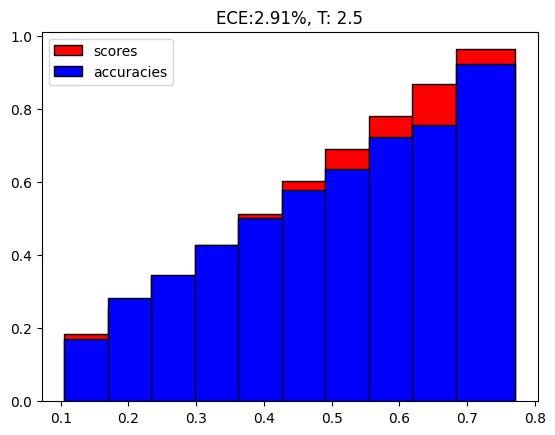

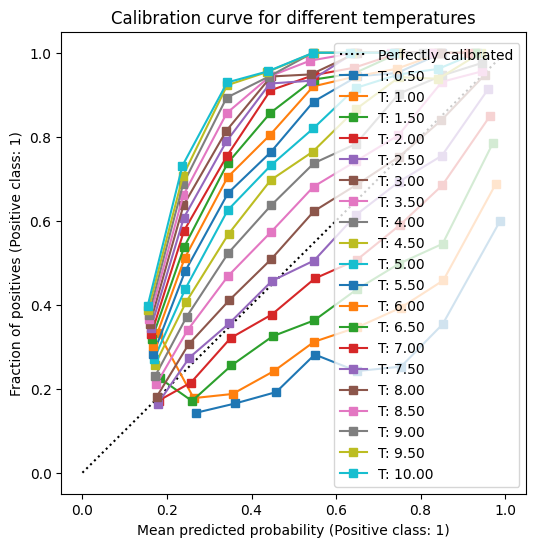

Accuracy: 0.5110


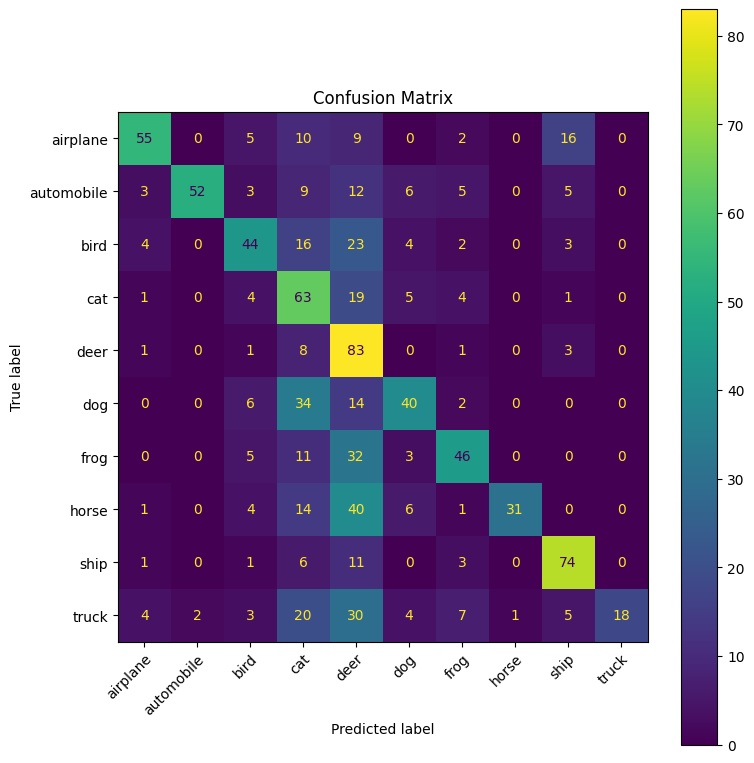

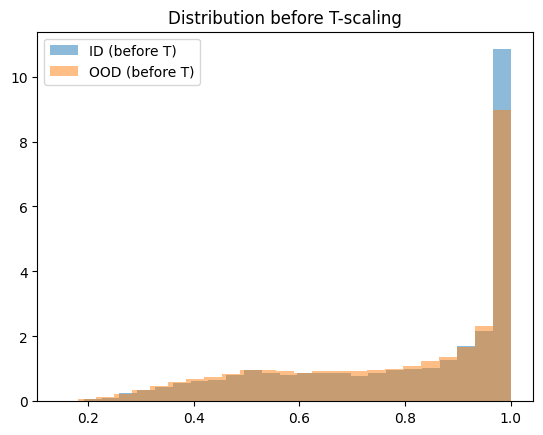

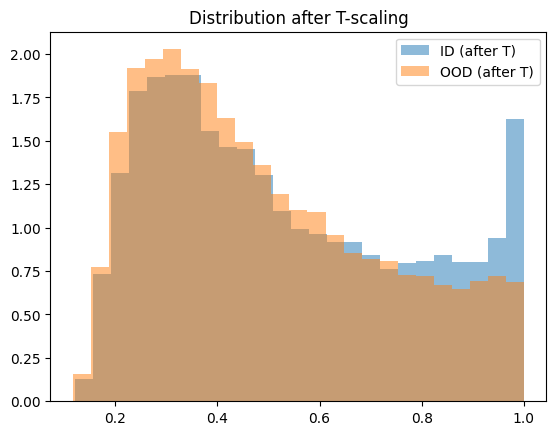

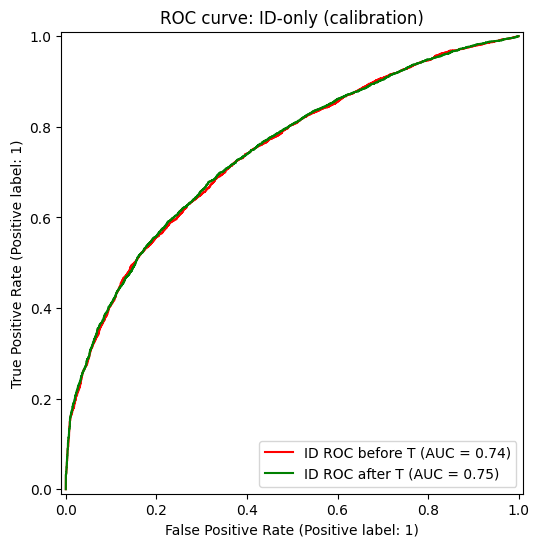

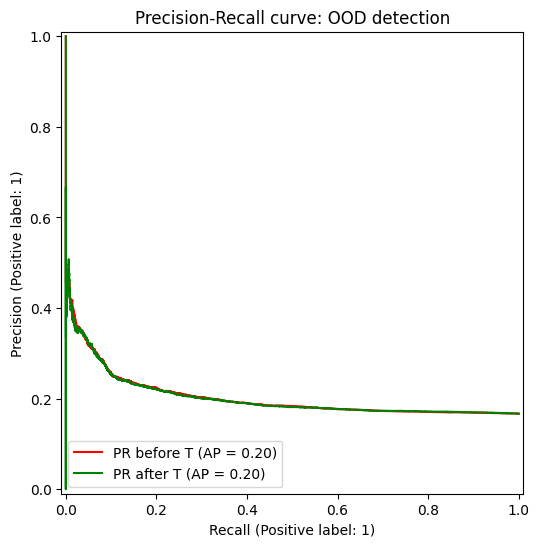

(2.5, 0.029147390460968012)

In [70]:
###see complete pipeline above####
T_scaling = [x/10 for x in range(5,105,5)]
OOD_pipeline(best_CNN,'cuda',ds_test,ds_OOD,128,4, T_scaling=T_scaling, plot_T_scaling=True, plot_performances=True)

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [71]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [72]:
for i,c in enumerate(ds_train.classes):
    print(i, c)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


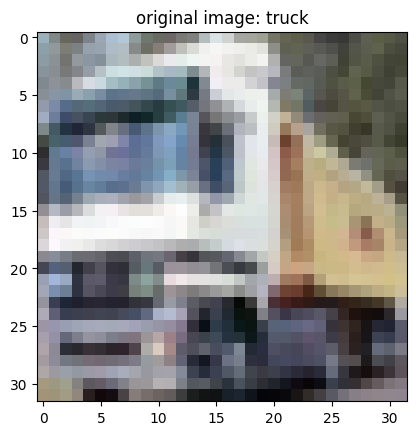

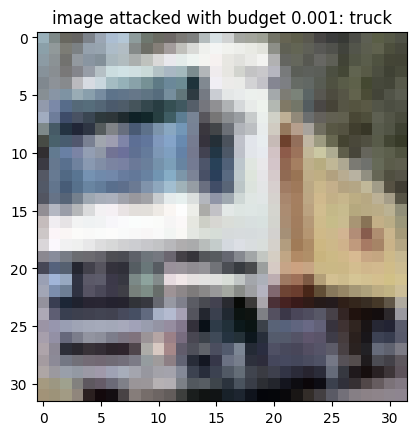

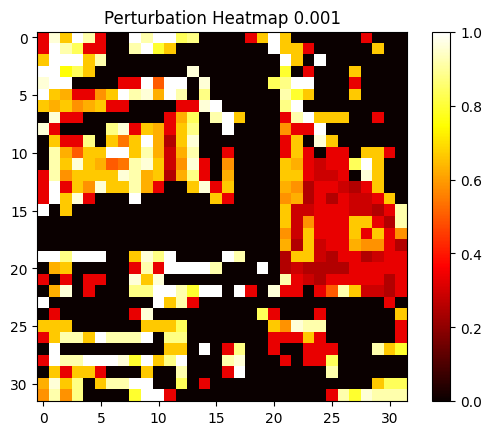

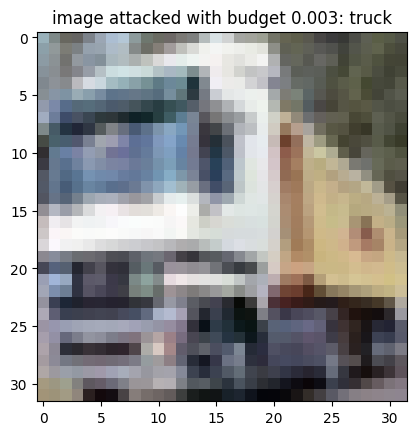

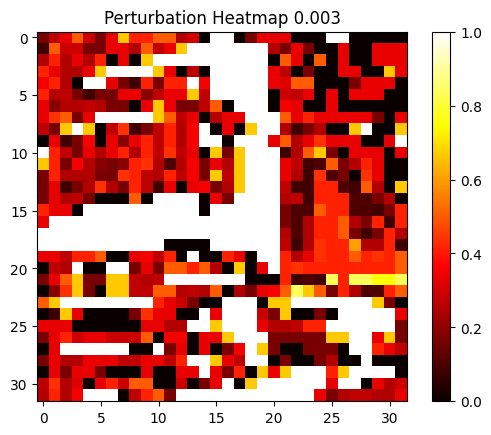

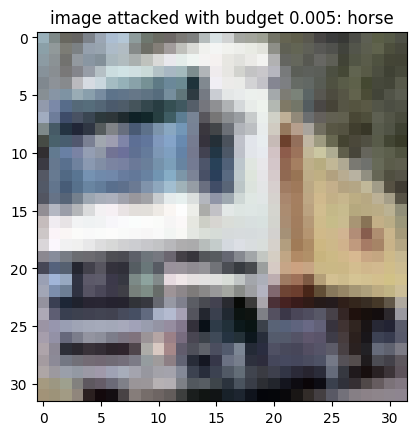

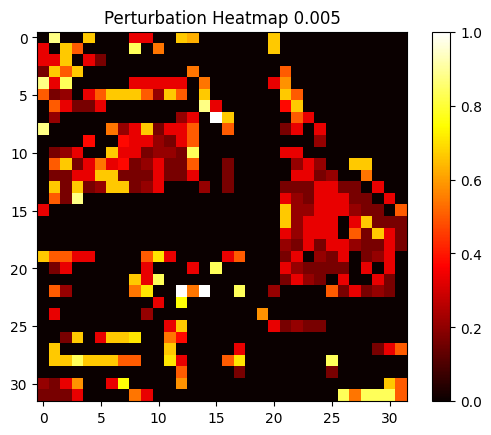

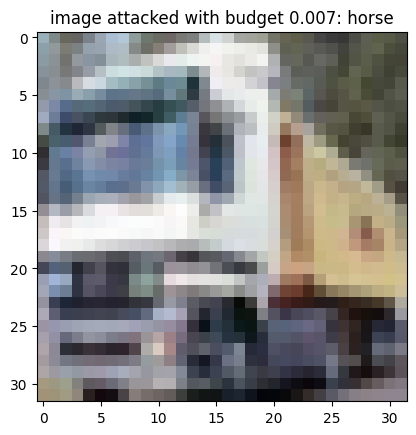

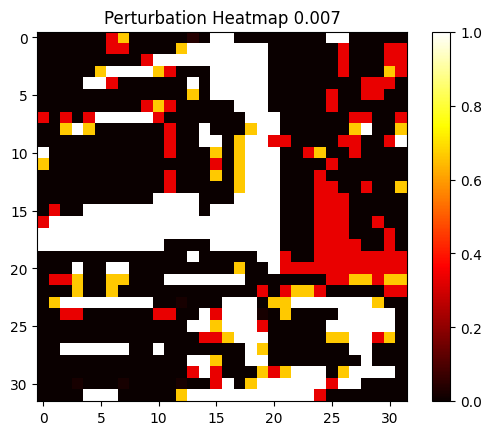

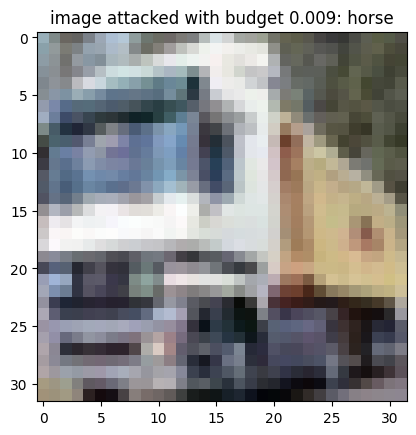

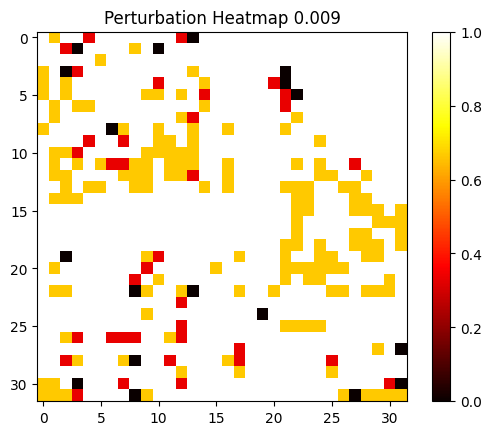

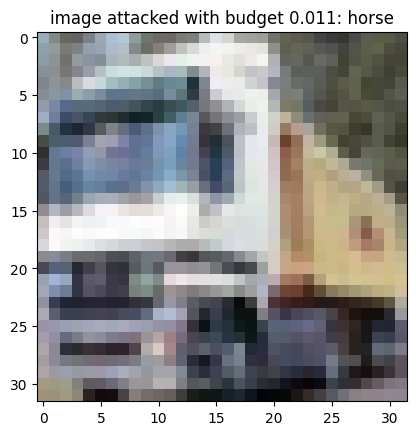

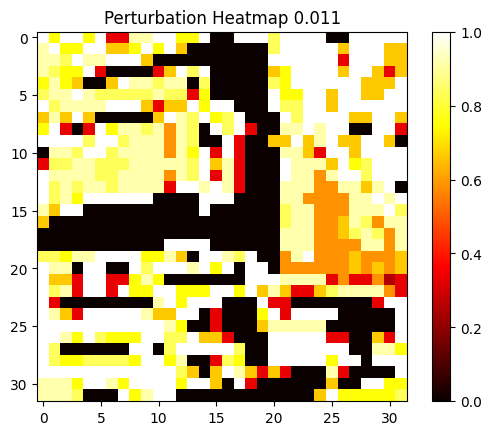

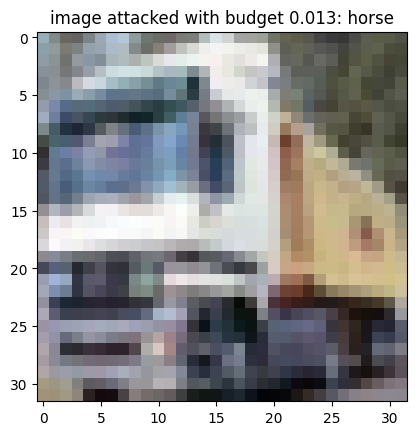

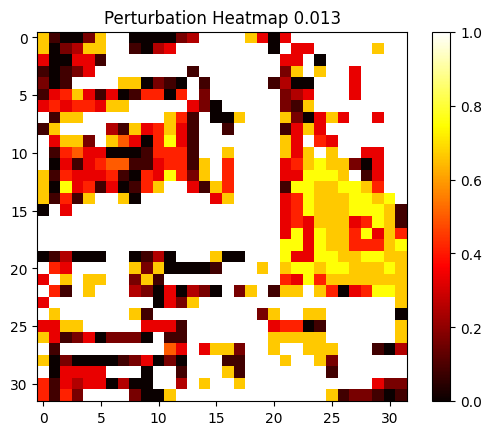

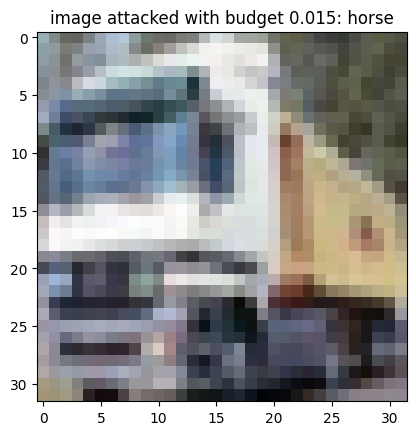

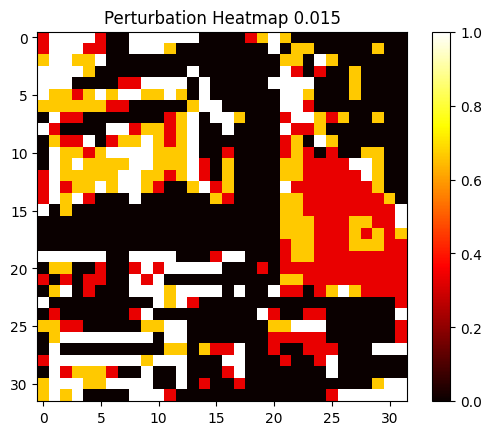

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011107716..1.0000001].


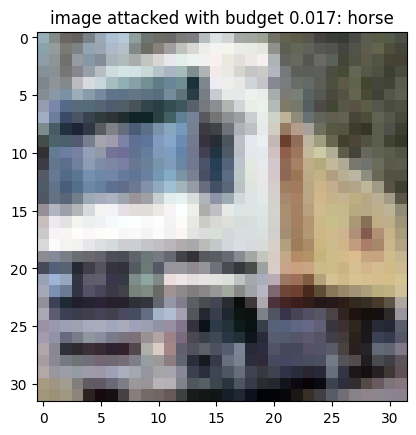

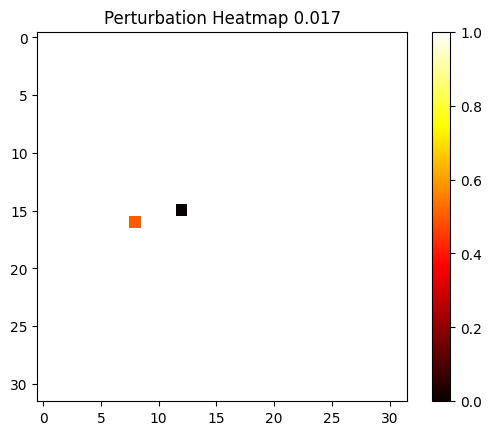

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010107729..1.0000001].


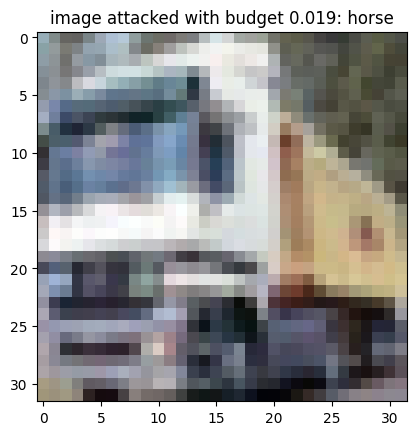

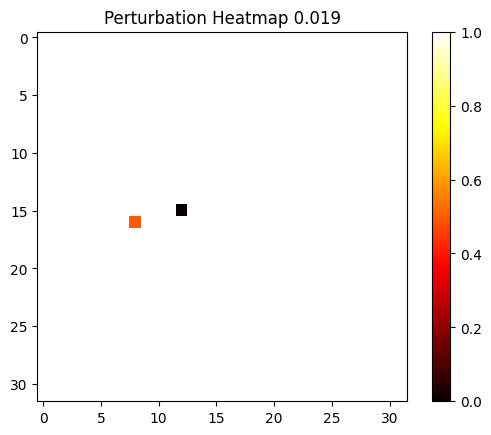

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009107711..1.0000001].


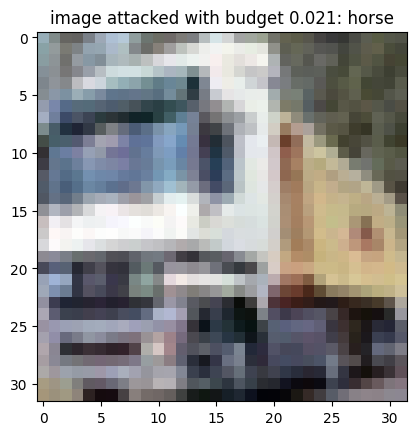

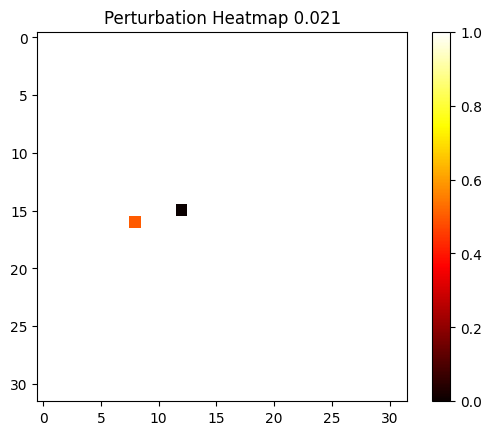

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.008107724..1.0000001].


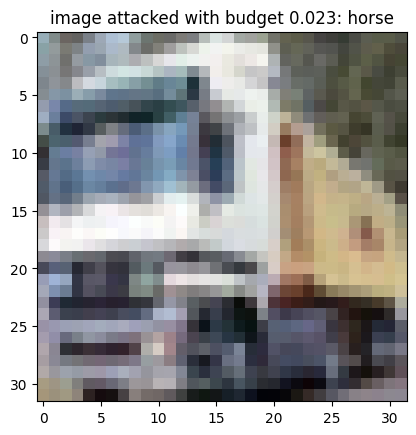

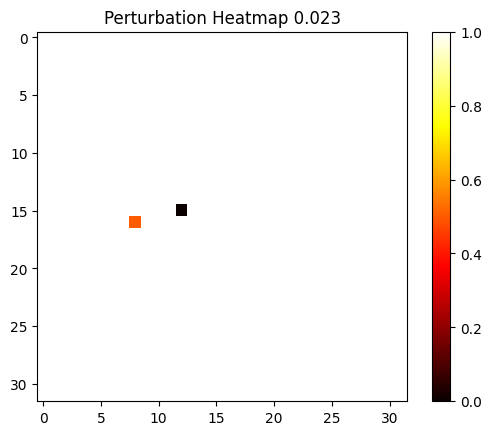

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0071077365..1.0000001].


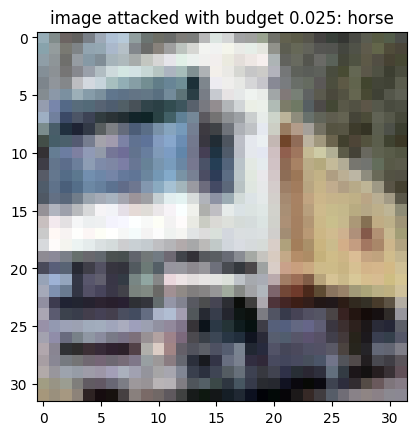

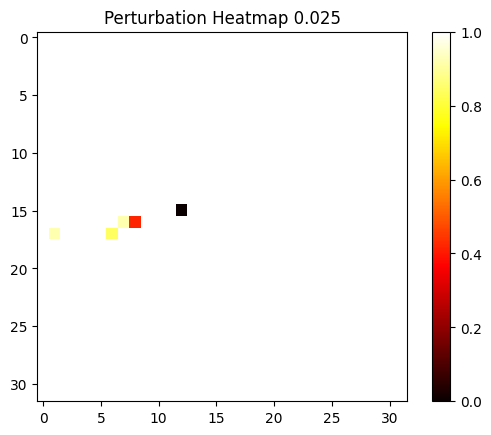

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.006107719..1.0000001].


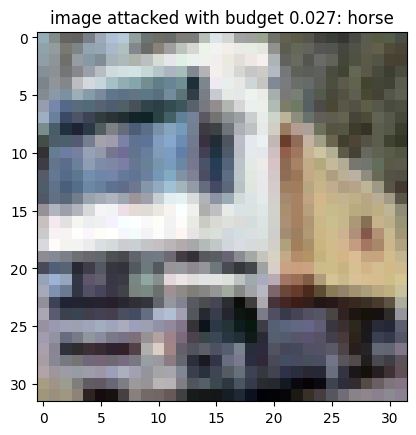

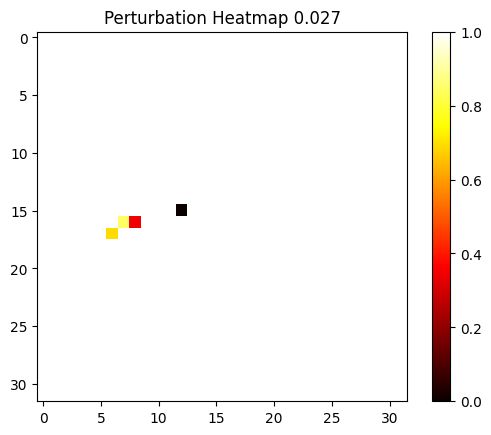

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.005107732..1.0000001].


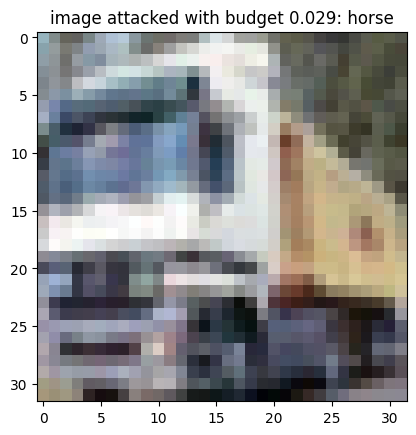

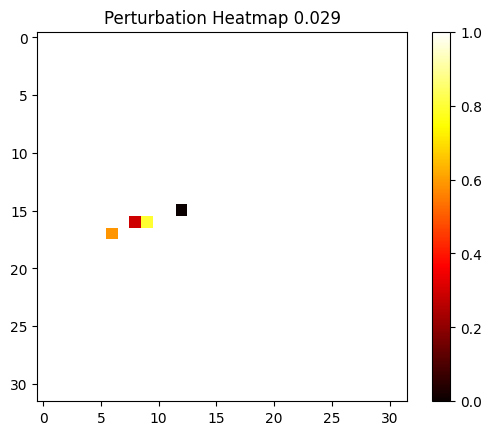

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0041077146..1.0000001].


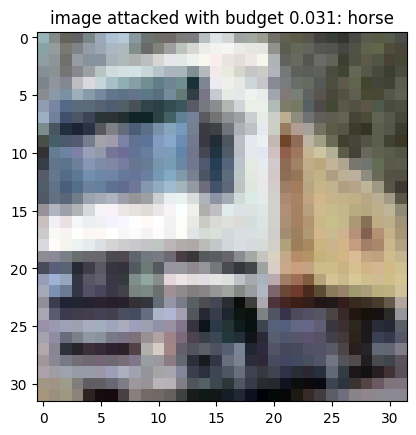

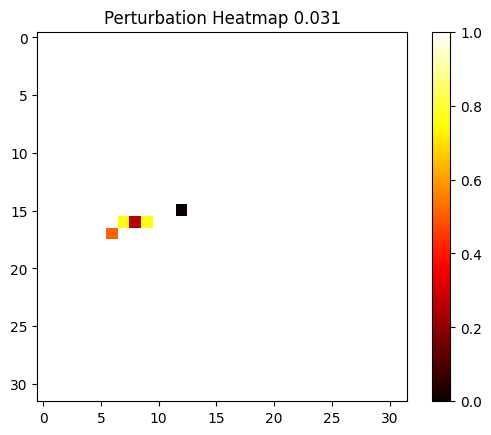

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0031077273..1.0000001].


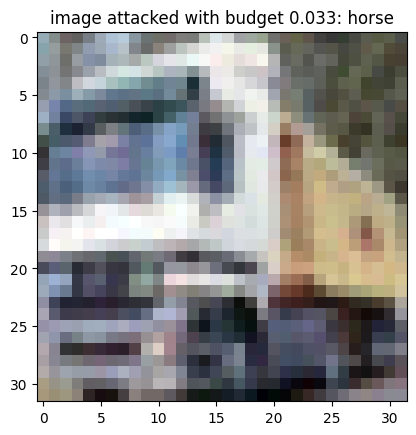

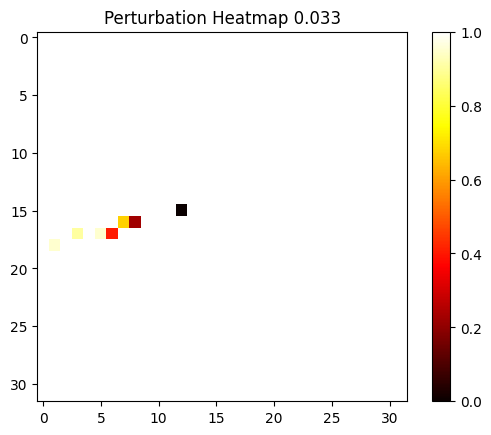

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00210771..1.0000001].


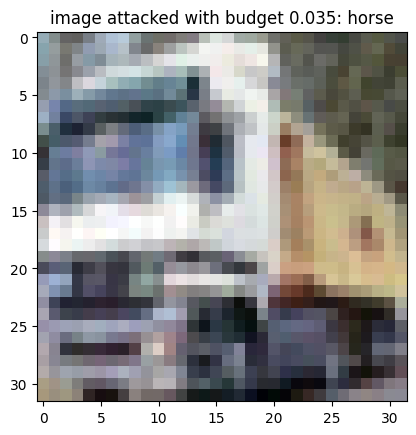

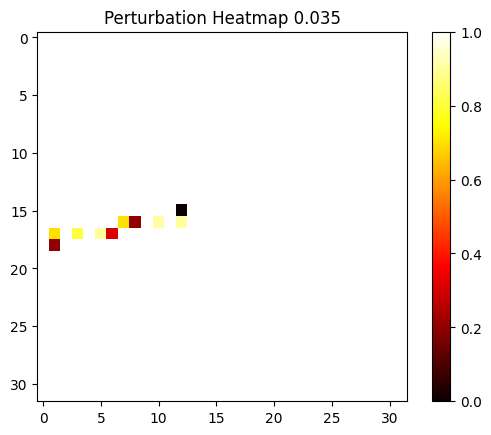

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0011077228..1.0000001].


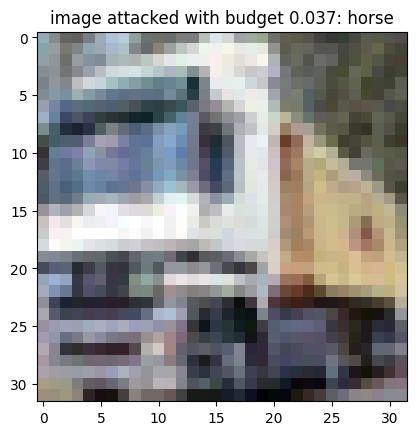

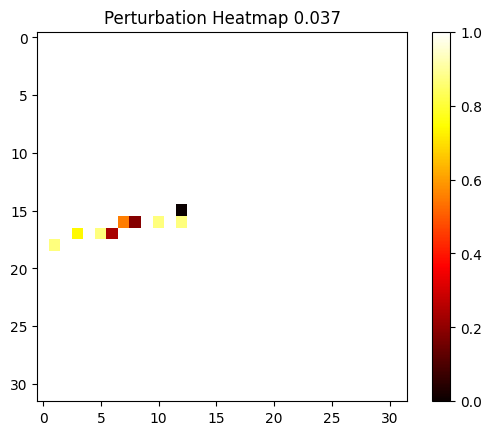

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.000107735425..1.0000001].


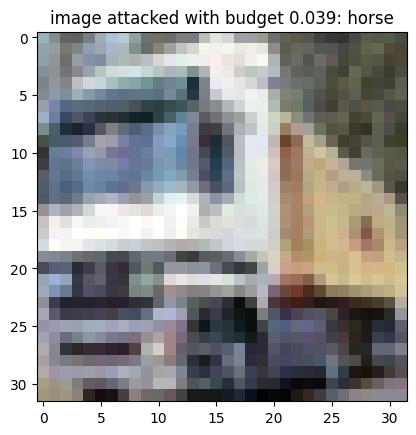

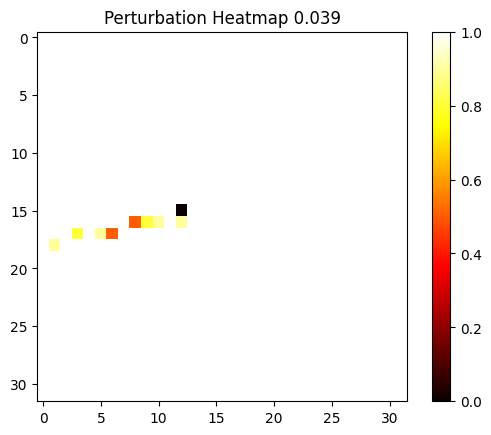

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


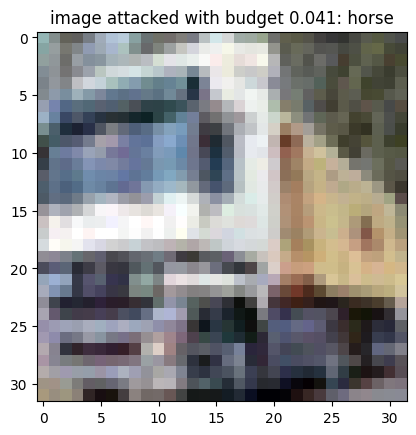

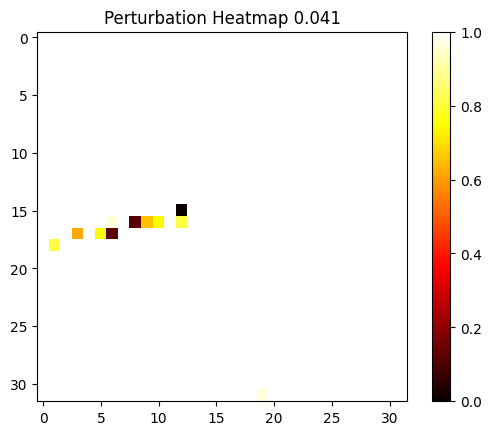

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


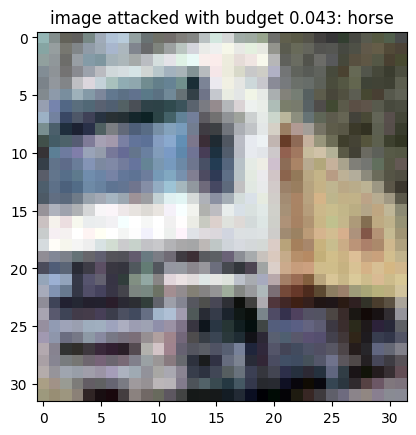

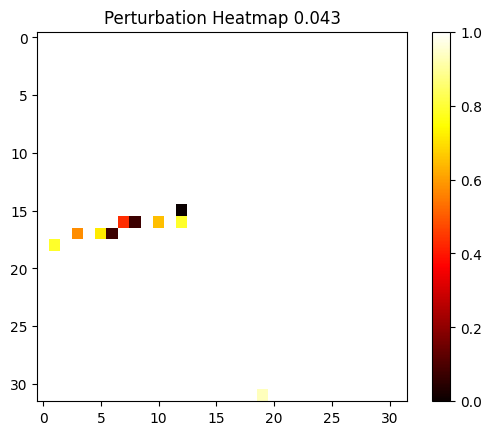

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


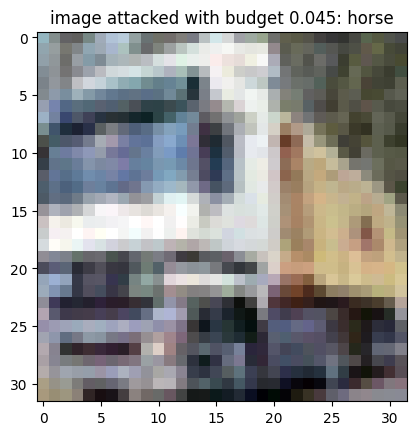

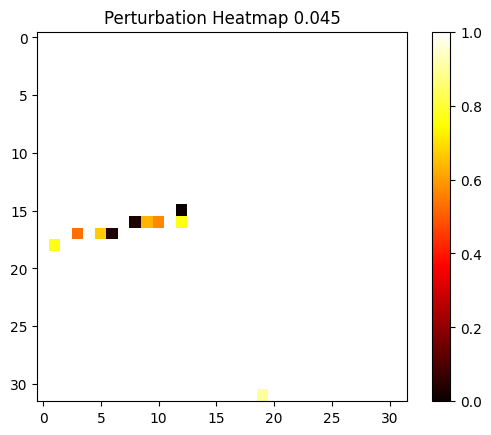

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


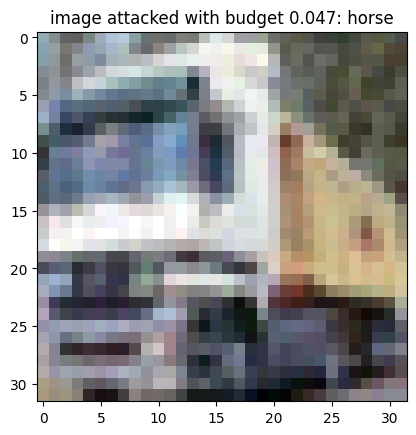

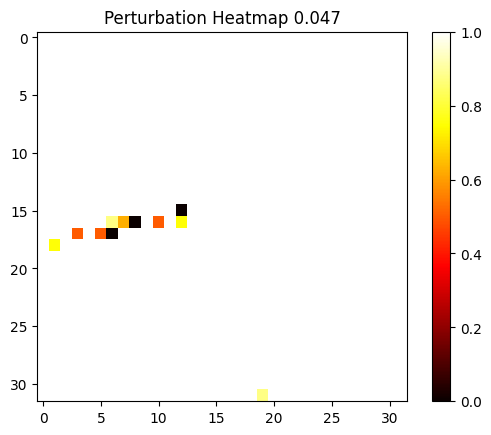

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


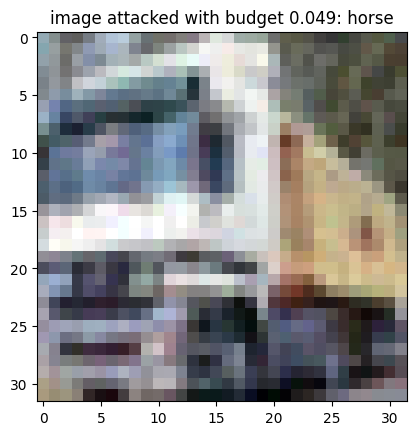

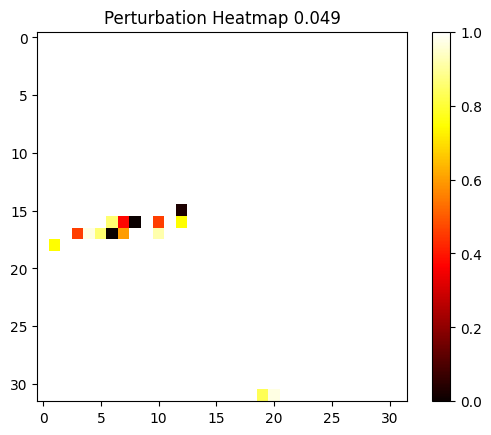

In [73]:
####untargeted FGSM evaluation (see fgsm function in training file)
example = ds_train[1]

device = 'cuda'

best_CNN.to(device)


best_CNN.eval()
output_clean = best_CNN(example[0].unsqueeze(0).to(device))

img = inv(example[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title('original image' + ': ' + str(ds_train.classes[output_clean.argmax()]))
plt.show()



#qualitative evaluation
for budget in range(1,50,2):
    budget = budget/1000
    x_adv = FGSM(x = example[0].unsqueeze(0).to(device),y_true = example[1],model =best_CNN,budget = budget)
    output = best_CNN(x_adv.to(device))

    img_adv = inv(x_adv[0])
    plt.imshow(img_adv.permute(1,2,0).detach().cpu())
    plt.title('image attacked with budget' +' ' + str(budget) + ': ' + ds_train.classes[output.argmax()])
    plt.show()

    diff = (x_adv.cpu() - example[0]).squeeze(0)

    heatmap = diff.abs().sum(dim=0)
    heatmap -= heatmap.min()
    heatmap /= heatmap.max()

    plt.imshow(heatmap.detach().cpu(), cmap='hot')
    plt.title("Perturbation Heatmap" + ' ' + str(budget))
    plt.colorbar()
    plt.show()


In [30]:
#quantitative evaluation
device = 'cuda'
psnr_list = []
l_inf_list = []

budgets = [b/1000 for b in range(1,50,2)]

correctly_classified = []

index = 0
while len(correctly_classified) <=100 :
    
    best_CNN.eval()
    output = best_CNN(ds_train[index][0].unsqueeze(0).to(device))
    y_pred = output.argmax()
    
    if y_pred == ds_train[index][1]:
        correctly_classified.append(ds_train[index])
    
    index += 1

linf_list, psnr_list = [],[]

for budget in budgets:
   
    linf = 0
    psnr = 0
    for example_index,example in enumerate(correctly_classified):
    
        x_adv = FGSM(x = example[0].unsqueeze(0).to(device),y_true = example[1],model = best_CNN,budget = budget)
        output = best_CNN(x_adv.to(device))
    
        diff = (x_adv.cpu() - example[0]).squeeze(0)
    
        linf = linf + diff.abs().max().item()
        mse = F.mse_loss(x_adv.cpu(), example[0].unsqueeze(0).cpu()).item()
        psnr = psnr + 10 * torch.log10(torch.tensor(4.0 / mse)).item()
    
    linf_list.append(linf/len(budgets))
    psnr_list.append(psnr/len(budgets))

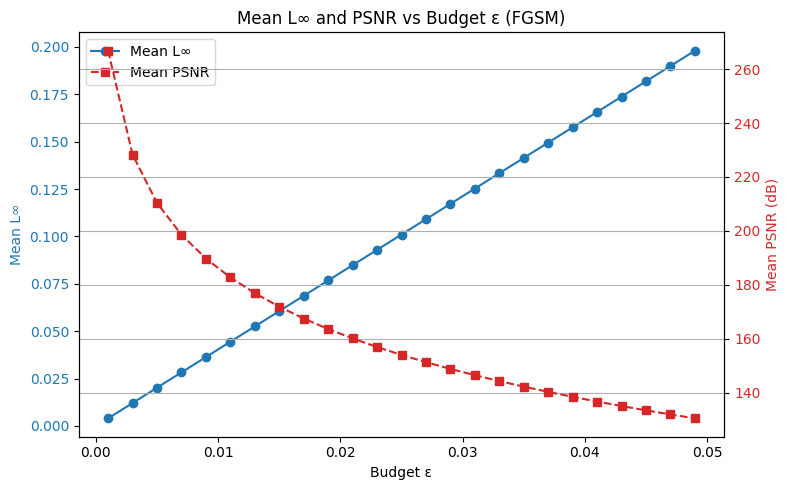

In [31]:
fig, ax1 = plt.subplots(figsize=(8, 5))

color_linf = 'tab:blue'
ax1.set_xlabel('Budget ε')
ax1.set_ylabel('Mean L∞', color=color_linf)
ax1.plot(budgets, linf_list, marker='o', color=color_linf, label='Mean L∞')
ax1.tick_params(axis='y', labelcolor=color_linf)

ax2 = ax1.twinx()

color_psnr = 'tab:red'
ax2.set_ylabel('Mean PSNR (dB)', color=color_psnr)
ax2.plot(budgets, psnr_list, marker='s', linestyle='--', color=color_psnr, label='Mean PSNR')
ax2.tick_params(axis='y', labelcolor=color_psnr)

plt.title('Mean L∞ and PSNR vs Budget ε (FGSM)')
fig.tight_layout()
plt.grid(True)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.show()


### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [74]:
trainer_config = {
    "device": 'cuda', 
    "num_workers": 4, 
    "seed": 42
}
augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

new_model = MyResNet(layers_deeper_net, data_shape=(3,32,32),skip_dict={1:2,6:8,10:11})

trainer = Trainer(config=trainer_config, model=new_model,optimizer = torch.optim.Adam(new_model.parameters(), lr=1e-3, weight_decay=1e-4),dataset=ds_train, lr=0.0001)
trainer.train(data_split=[0.4, 0.6], batch_size=64, num_epochs=100, early_stopping=5, val_check=1, use_wandb=False, augmentation=(0.3,augment), checks=False,fgsm = [0.05])

running on device cuda


Training epoch 0: 100%|██████████| 610/610 [01:59<00:00,  5.10it/s]

Epoch 0/100, Average training loss: 1.9303


Epoch 0/100, Training accuracy: 0.4709


Validation epoch 0: 100%|██████████| 313/313 [00:01<00:00, 178.43it/s]

Epoch 0/100, Average validation loss: 1.5293


Epoch 0/100, Validation accuracy: 0.4563


Training epoch 1: 100%|██████████| 610/610 [01:53<00:00,  5.38it/s]

Epoch 1/100, Average training loss: 1.7426


Epoch 1/100, Training accuracy: 0.5623


Validation epoch 1: 100%|██████████| 313/313 [00:01<00:00, 162.55it/s]

Epoch 1/100, Average validation loss: 1.3801


Epoch 1/100, Validation accuracy: 0.5357


Training epoch 2: 100%|██████████| 610/610 [01:57<00:00,  5.18it/s]

Epoch 2/100, Average training loss: 1.6162


Epoch 2/100, Training accuracy: 0.5853


Validation epoch 2: 100%|██████████| 313/313 [00:01<00:00, 170.67it/s]

Epoch 2/100, Average validation loss: 1.2625


Epoch 2/100, Validation accuracy: 0.5473


Training epoch 3: 100%|██████████| 610/610 [01:55<00:00,  5.26it/s]

Epoch 3/100, Average training loss: 1.5133


Epoch 3/100, Training accuracy: 0.6460


Validation epoch 3: 100%|██████████| 313/313 [00:01<00:00, 176.30it/s]

Epoch 3/100, Average validation loss: 1.1236


Epoch 3/100, Validation accuracy: 0.5926


Training epoch 4: 100%|██████████| 610/610 [01:56<00:00,  5.25it/s]

Epoch 4/100, Average training loss: 1.4057


Epoch 4/100, Training accuracy: 0.7163


Validation epoch 4: 100%|██████████| 313/313 [00:01<00:00, 174.95it/s]

Epoch 4/100, Average validation loss: 1.0800


Epoch 4/100, Validation accuracy: 0.6450


Training epoch 5: 100%|██████████| 610/610 [02:05<00:00,  4.86it/s]

Epoch 5/100, Average training loss: 1.3068


Epoch 5/100, Training accuracy: 0.7455


Validation epoch 5: 100%|██████████| 313/313 [00:02<00:00, 155.72it/s]

Epoch 5/100, Average validation loss: 1.0407


Epoch 5/100, Validation accuracy: 0.6503


Training epoch 6: 100%|██████████| 610/610 [02:03<00:00,  4.92it/s]

Epoch 6/100, Average training loss: 1.2088


Epoch 6/100, Training accuracy: 0.7915


Validation epoch 6: 100%|██████████| 313/313 [00:01<00:00, 176.29it/s]

Epoch 6/100, Average validation loss: 0.9867


Epoch 6/100, Validation accuracy: 0.6702


Training epoch 7: 100%|██████████| 610/610 [02:00<00:00,  5.08it/s]

Epoch 7/100, Average training loss: 1.1130


Epoch 7/100, Training accuracy: 0.8061


Validation epoch 7: 100%|██████████| 313/313 [00:01<00:00, 177.89it/s]

Epoch 7/100, Average validation loss: 0.9740


Epoch 7/100, Validation accuracy: 0.6687


Training epoch 8: 100%|██████████| 610/610 [02:02<00:00,  4.97it/s]

Epoch 8/100, Average training loss: 1.0169


Epoch 8/100, Training accuracy: 0.8414


Validation epoch 8: 100%|██████████| 313/313 [00:02<00:00, 153.15it/s]

Epoch 8/100, Average validation loss: 0.9620


Epoch 8/100, Validation accuracy: 0.6673


Training epoch 9: 100%|██████████| 610/610 [01:54<00:00,  5.31it/s]

Epoch 9/100, Average training loss: 0.9240


Epoch 9/100, Training accuracy: 0.8663


Validation epoch 9: 100%|██████████| 313/313 [00:01<00:00, 170.64it/s]

Epoch 9/100, Average validation loss: 0.9557


Epoch 9/100, Validation accuracy: 0.6684


Training epoch 10: 100%|██████████| 610/610 [02:04<00:00,  4.88it/s]

Epoch 10/100, Average training loss: 0.8502


Epoch 10/100, Training accuracy: 0.8768


Validation epoch 10: 100%|██████████| 313/313 [00:02<00:00, 153.79it/s]

Epoch 10/100, Average validation loss: 0.9536


Epoch 10/100, Validation accuracy: 0.6751


Training epoch 11: 100%|██████████| 610/610 [02:06<00:00,  4.84it/s]

Epoch 11/100, Average training loss: 0.7717


Epoch 11/100, Training accuracy: 0.9103


Validation epoch 11: 100%|██████████| 313/313 [00:01<00:00, 175.13it/s]

Epoch 11/100, Average validation loss: 0.9863


Epoch 11/100, Validation accuracy: 0.6874


Training epoch 12: 100%|██████████| 610/610 [01:52<00:00,  5.41it/s]

Epoch 12/100, Average training loss: 0.7062


Epoch 12/100, Training accuracy: 0.9296


Validation epoch 12: 100%|██████████| 313/313 [00:01<00:00, 177.08it/s]

Epoch 12/100, Average validation loss: 0.9896


Epoch 12/100, Validation accuracy: 0.6979
Early stopping triggered!


Accuracy: 0.8314


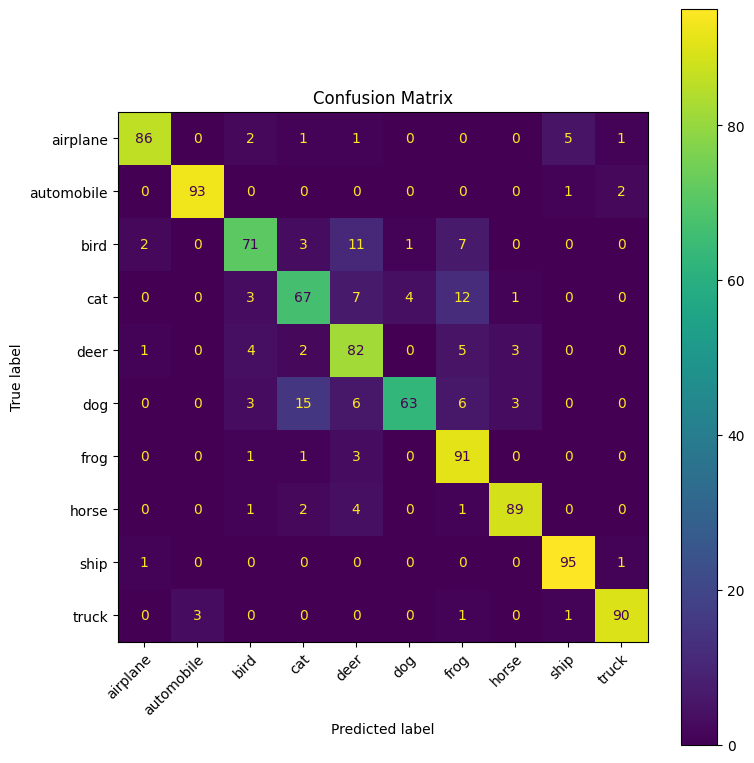

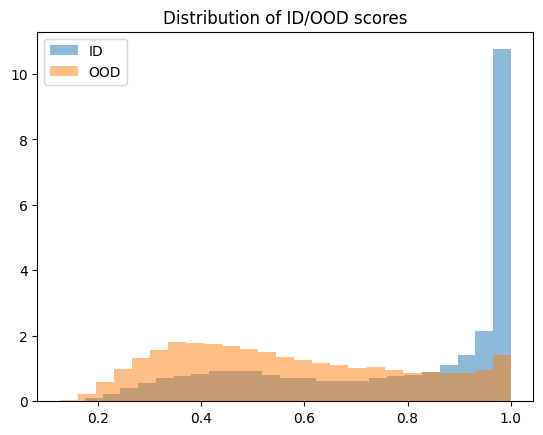

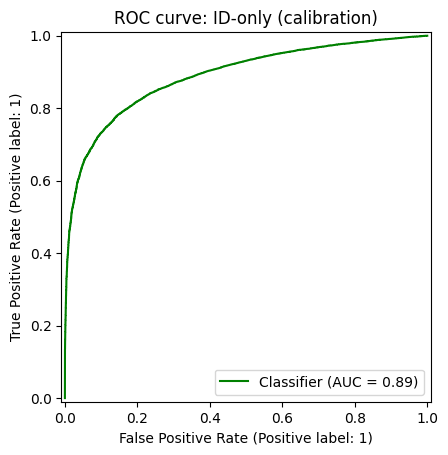

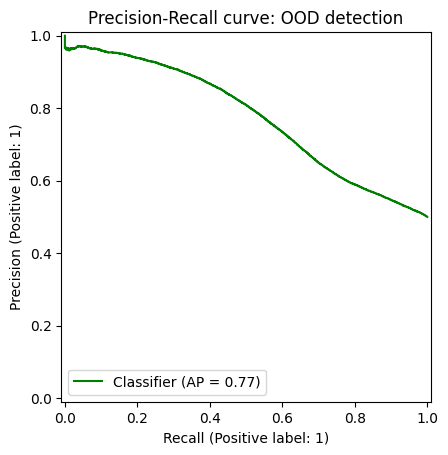

In [75]:
OOD_pipeline(new_model,'cuda',ds_train,ds_OOD,128,4, plot_performances=True)

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


In [33]:
classes_dict = {k:v for v,k in enumerate(ds_train.classes)}

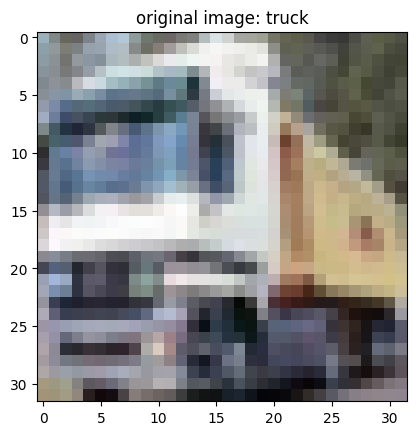

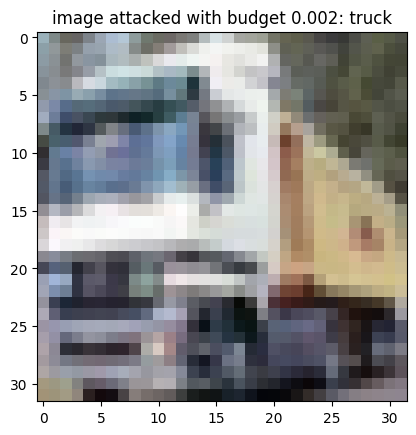

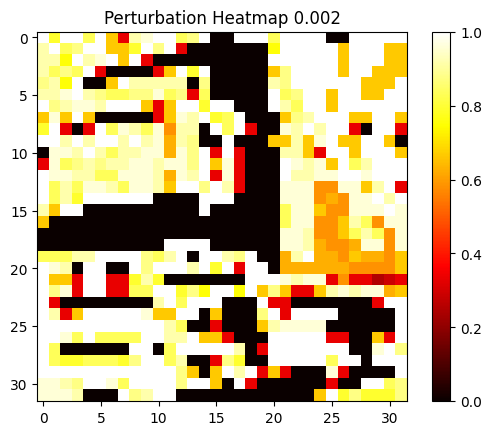

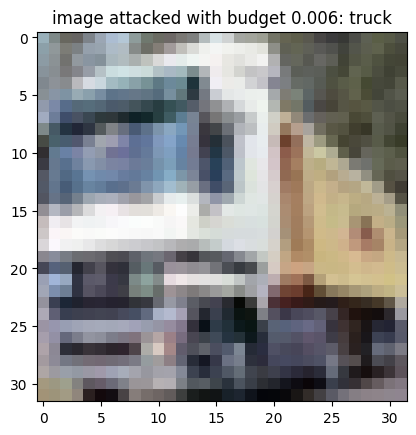

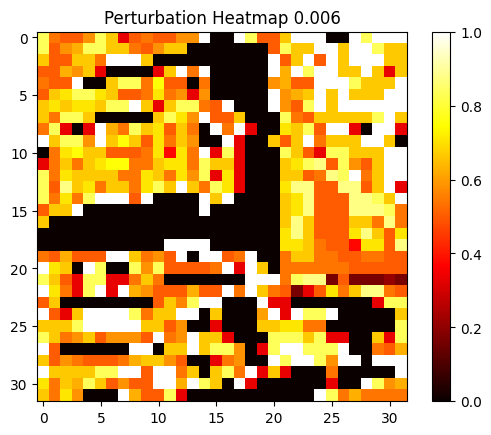

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.014607731..1.0000001].


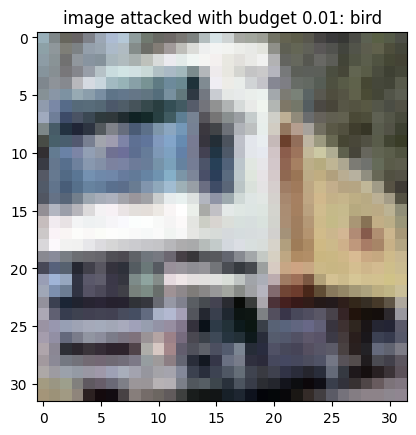

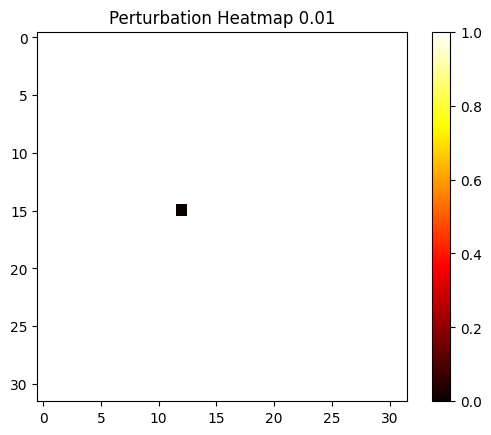

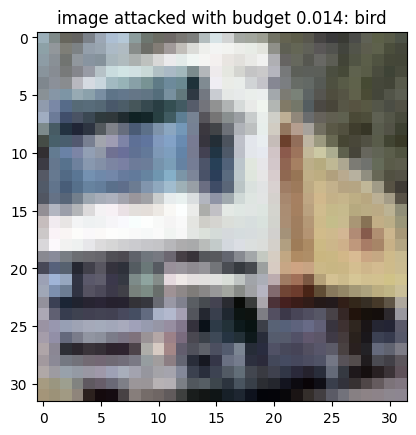

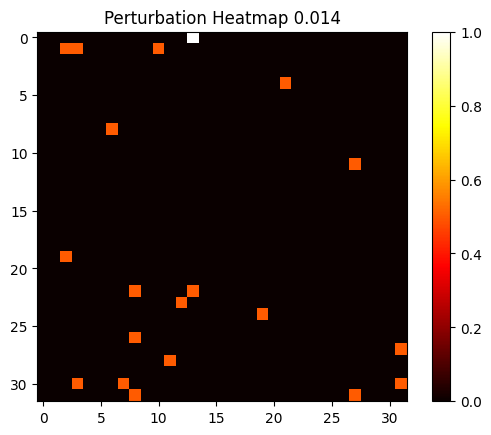

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.014529292..1.0000001].


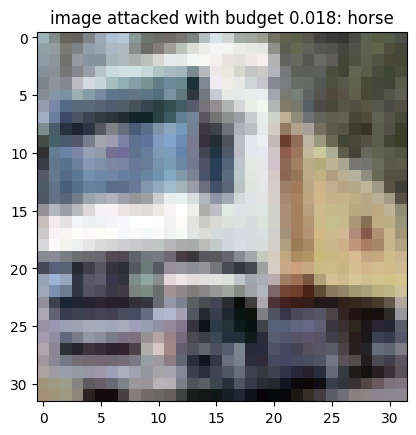

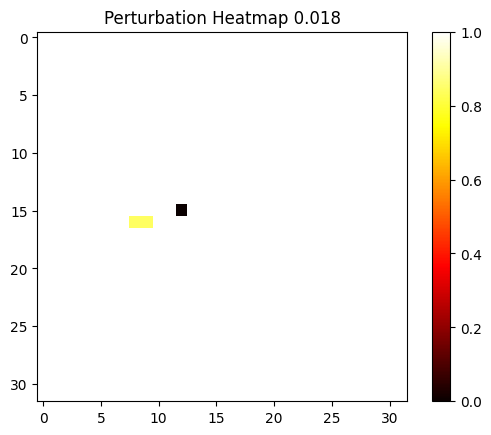

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.008607717..1.0000001].


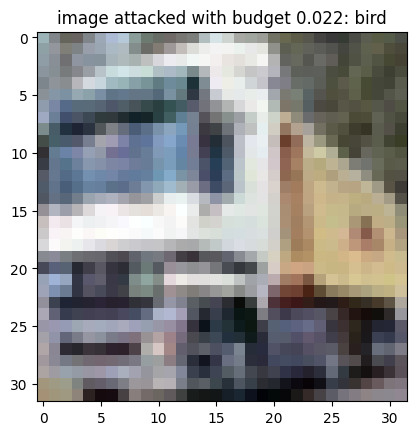

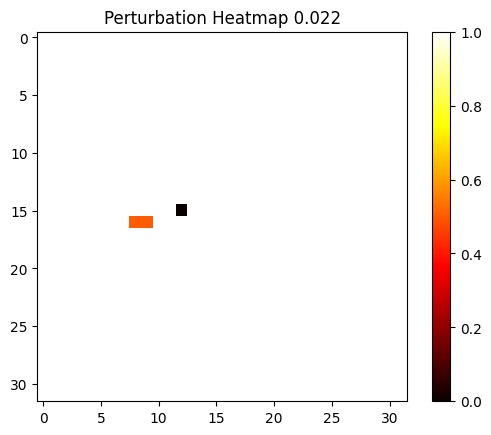

In [37]:
####targeted FGSM evaluation (see fgsm function in training file)
example = ds_train[1]

device = 'cuda'

best_CNN.to(device)


best_CNN.eval()
output_clean = best_CNN(example[0].unsqueeze(0).to(device))

img = inv(example[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title('original image' + ': ' + str(ds_train.classes[output_clean.argmax()]))
plt.show()


y_target = classes_dict['bird']

#qualitative evaluation
for budget in range(1,13,2):
    budget = budget/500
    x_adv = FGSM(x = example[0].unsqueeze(0).to(device),y_true=None,model = best_CNN,budget=budget, y_target=y_target)
    output = best_CNN(x_adv.to(device))

    img_adv = inv(x_adv[0])
    plt.imshow(img_adv.permute(1,2,0).detach().cpu())
    plt.title('image attacked with budget' +' ' + str(budget) + ': ' + ds_train.classes[output.argmax()])
    plt.show()

    diff = (x_adv.cpu() - example[0]).squeeze(0)

    heatmap = diff.abs().sum(dim=0)
    heatmap -= heatmap.min()
    heatmap /= heatmap.max()

    plt.imshow(heatmap.detach().cpu(), cmap='hot')
    plt.title("Perturbation Heatmap" + ' ' + str(budget))
    plt.colorbar()
    plt.show()


In [55]:
#quantitative evaluation
device = 'cuda'
psnr_list = []
l_inf_list = []

budgets = [b/500 for b in range(1,13,2)]

correctly_classified = []

index = 0
while len(correctly_classified) <=100 :
    
    best_CNN.eval()
    output = best_CNN(ds_train[index][0].unsqueeze(0).to(device))
    y_pred = output.argmax()
    
    if y_pred == ds_train[index][1]:
        correctly_classified.append(ds_train[index])
    
    index += 1

linf_list, psnr_list = [],[]

for budget in budgets:
   
    linf = 0
    psnr = 0
    for example_index,example in enumerate(correctly_classified):
    
        x_adv = FGSM(x = example[0].unsqueeze(0).to(device),y_target=y_target ,model = best_CNN,budget = budget)
        output = best_CNN(x_adv.to(device))
    
        diff = (x_adv.cpu() - example[0]).squeeze(0)
    
        linf = linf + diff.abs().max().item()
        mse = F.mse_loss(x_adv.cpu(), example[0].unsqueeze(0).cpu()).item()
        psnr = psnr + 10 * torch.log10(torch.tensor(4.0 / mse)).item()
    
    linf_list.append(linf/len(budgets))
    psnr_list.append(psnr/len(budgets))

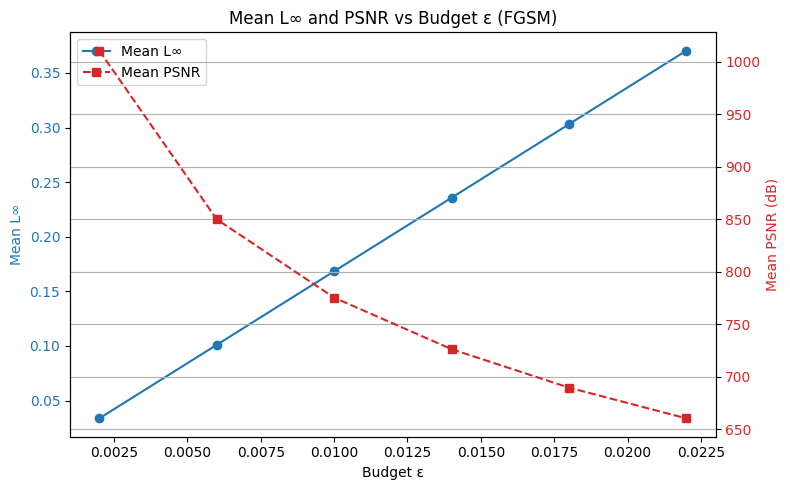

In [57]:
fig, ax1 = plt.subplots(figsize=(8, 5))

color_linf = 'tab:blue'
ax1.set_xlabel('Budget ε')
ax1.set_ylabel('Mean L∞', color=color_linf)
ax1.plot(budgets, linf_list, marker='o', color=color_linf, label='Mean L∞')
ax1.tick_params(axis='y', labelcolor=color_linf)

ax2 = ax1.twinx()

color_psnr = 'tab:red'
ax2.set_ylabel('Mean PSNR (dB)', color=color_psnr)
ax2.plot(budgets, psnr_list, marker='s', linestyle='--', color=color_psnr, label='Mean PSNR')
ax2.tick_params(axis='y', labelcolor=color_psnr)

plt.title('Mean L∞ and PSNR vs Budget ε (FGSM)')
fig.tight_layout()
plt.grid(True)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.show()
